One of the reasons we decided to focus on SliceMatrix-IO as Platform as a Service (PaaS) API was to make it play nicely with other systems. The Bloomberg terminal is one of the most widely used sources of data in the financial world, so we wanted to present a quick notebook which shows how to integrate SliceMatrix-IO and "The Bloomberg" in a way few thought possible. 

First let's create an IO client to do our bidding. Remember to substitute your api key in the code below.


In [1]:
from slicematrixIO import SliceMatrix

api_key = "insert your key here"
sm = SliceMatrix(api_key)

In order to connect to the Bloomberg terminal in Python, we're going to make use of the <a href = "https://github.com/bpsmith/tia">tia</a> package. This can be installed with pip:

>pip install tia

Now we can import everything we need for Bloomberg-ing...

In [2]:
from tia.bbg import LocalTerminal
import tia.bbg.datamgr as dm

Plus some good friends...

In [3]:
import pandas as pd
import numpy as np
import datetime as dt

Now let's create a function for getting the components of a given stock index. To anyone familiar with punching keys into a terminal, you might recognize some of these commands...

In [4]:
def get_index_members(index_name):
    components = LocalTerminal.get_reference_data(index_name,'INDX_MEMBERS')
    components=components.as_frame()
    components=components['INDX_MEMBERS'][0]
    components = map(lambda x: x+" Equity", list(components["Member Ticker and Exchange Code"]))
    components     = [component[:-9] + "US Equity" for component in components]
    return components

When you create a weapon you want to use it... to get the S&P 500 components ;-)

In [5]:
stocks=get_index_members('SPX Index')
print stocks[0:10], '...', stocks[-10:-1]

['A US Equity', 'AAL US Equity', 'AAP US Equity', 'AAPL US Equity', 'ABBV US Equity', 'ABC US Equity', 'ABT US Equity', 'ACN US Equity', 'ADBE US Equity', 'ADI US Equity'] ... ['XLNX US Equity', 'XOM US Equity', 'XRAY US Equity', 'XRX US Equity', 'XYL US Equity', 'YHOO US Equity', 'YUM US Equity', 'ZBH US Equity', 'ZION US Equity']


The main vector for getting data out of tia is the BbgDataManager

In [6]:
data_manager = dm.BbgDataManager()

We can use this object to grab the data we want: in this case the daily closing prices over the last year

In [7]:
prices = data_manager[stocks].get_historical('PX_LAST', '3/8/2012', '3/8/2017')

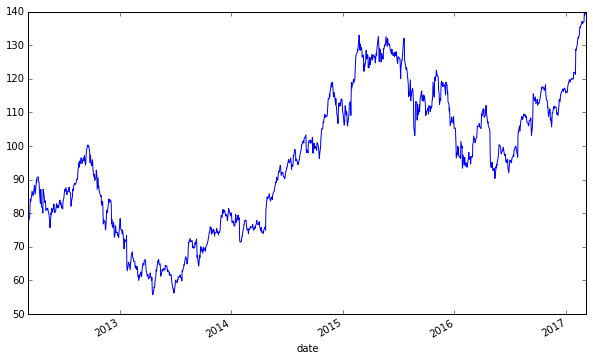

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
prices['AAPL US Equity'].plot(figsize = (10,6))
plt.show()

Then taking log-differences...

In [9]:
cols = prices.columns
prices.columns = [column.replace("US Equity", "") for column in cols]
diffs = np.log(prices).diff().dropna(axis = 0, how = "all").dropna(axis = 1, how = "any")
diffs.head() 

,BF/B,DLTR,EMN,GRMN,TRIP,NBL,KR,MAR,L,DOV,...,CTL,ULTA,PFE,SJM,NEM,KLAC,PBCT,UDR,JEC,BHI
date,,,,,,,,,,,,,,,,,,,,,
2012-03-09,0.002502,0.005924,-0.007461,0.001685,-0.018077,0.011251,-0.000822,0.021541,0.008575,0.012751,...,0.007718,0.000090,0.001165,-0.001722,-0.001230,0.031005,0.007203,0.017330,0.005522,0.000820
2012-03-12,0.007975,0.002360,-0.007517,-0.001053,0.000000,-0.004777,0.002464,-0.001600,-0.002072,-0.000791,...,-0.001026,-0.009227,0.002789,0.000265,-0.020066,0.007252,0.001594,0.008554,-0.007739,-0.024903
2012-03-13,0.013064,0.001713,0.008284,0.002315,-0.007192,0.015288,-0.006584,0.023208,0.018750,0.023497,...,0.009701,0.017259,0.021585,0.010939,-0.016093,0.015140,0.022827,0.012313,0.029526,0.021001
2012-03-14,-0.013686,0.007034,-0.011579,0.006496,0.016594,0.006845,0.004942,0.000782,-0.007150,-0.010271,...,-0.004073,-0.006018,-0.003641,-0.003940,-0.010260,0.001383,0.008138,-0.006522,-0.013452,-0.014508
2012-03-15,-0.006352,-0.006927,0.008312,-0.016213,0.046652,0.008516,0.002872,-0.000261,0.013744,0.003747,...,0.000255,0.010121,-0.000912,0.023025,-0.008508,0.023994,0.024777,-0.008892,0.023530,-0.006493


One of the most useful ways to visualize the stock market is with Minimum Spanning Trees (MST). These are network graphs in which each vertex represents a stock symbol and where strongly related stocks are connected by edges.

One popular way to do this is by using correlation matrices. The next function constructs an MST by transforming the price correlation matrix for a group of stocks into a distance matrix using a metric function.

In [10]:
mst = sm.MinimumSpanningTree(dataset = diffs.T)

Then let's use the slicematrixIO-python.notebook module to visualize the Minimum Spanning Tree

In [11]:
from slicematrixIO.notebook import GraphEngine
viz = GraphEngine(sm)

initializing window.graph_data


In [12]:
viz.init_style()

In [13]:
viz.init_data()

<IPython.core.display.Javascript object>

In [14]:
viz.drawNetworkGraph(mst, width = 1000, height = 500, min_node_size = 10, charge = -25, color_map = "Heat", color_axis = "eccentricity", graph_layout = "force", label_color = "rgba(255,255,255,0.88)", graph_style = "dark")

<IPython.core.display.Javascript object>

Another way to construct a network graph from the correlation matrix is using another algorithm called the correlation filtered graph. While the MST is restricted to creating a <i>tree</i>, the CFG can create a graph with loops:

In [15]:
cfg = sm.CorrelationFilteredGraph(dataset = diffs.T)

In [16]:
viz.drawNetworkGraph(cfg, width = 1000, height = 500, min_node_size = 10, charge = -25, color_map = "RdBuGn", color_axis = "closeness_centrality", graph_layout = "force", label_color = "rgba(255,255,255,0.88)", graph_style = "dark")

<IPython.core.display.Javascript object>

Each network graph contains a number of unique factors describing the systemic importance of the stock within the market graph. These factors can be accessed directly via:

In [18]:
cfg.rankNodes(statistic = "degree_centrality").head(20)

,degree_centrality
ZION,0.006263
PPL,0.006263
FLIR,0.006263
PNR,0.006263
PHM,0.006263
PGR,0.006263
PG,0.006263
PDCO,0.006263
FSLR,0.006263
FTI,0.006263
